In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 150

In [191]:
import h5py
import json
import fitsio
import numpy as np
import pandas as pd
from astropy.wcs import WCS
from itertools import product
import matplotlib.pyplot as pl
from scipy.linalg import cho_factor, cho_solve
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import FastICA, RandomizedPCA

In [198]:
with open("k2.wcs.json", "r") as f:
    wcs = WCS(json.load(f))

In [199]:
df = pd.read_csv("K2_var.dat", delim_whitespace=True, names=[
    "ID", "RA", "DEC", "X", "Y", "Mag_Sch", "Mag_K2", "Phot_K2", "Clas_K2", "Period",
    "ID_Nar", "ID_Hu", "ID_Hu", "ID_Kim", "ID_Mei", "ID_Moc", "B", "V", "R",
    "J_2MASS", "H_2MASS", "K_2MASS", 
])
df = df[df.Clas_K2 == 1]

In [228]:
ra = np.array(df.RA)
dec = np.array(df.DEC)
x, y = wcs.all_world2pix(ra, dec, 1)
df["k2_cx"] = x
df["k2_cy"] = y
print(x.min(), x.max(), y.min(), y.max())

6.47309067761 842.618822315 17.4438291402 649.500747629


In [469]:
df[df.J_2MASS > 14].sort("J_2MASS")

,ID,RA,DEC,X,Y,Mag_Sch,Mag_K2,Phot_K2,Clas_K2,Period,...,ID_Mei,ID_Moc,B,V,R,J_2MASS,H_2MASS,K_2MASS,k2_cx,k2_cy
151,3464,91.770158,23.988426,3401.7183,352.9890,-12.6841,15.2568,2,1,0.401891,...,-1,-1,16.0587,15.3444,15.1896,14.001,13.753,13.718,782.405927,449.615643
953,12644,92.198202,24.161670,1765.7593,1065.8515,-12.3598,15.4538,2,1,5.473107,...,288,-1,16.6910,15.7034,15.4137,14.005,13.555,13.443,402.605991,374.294605
1287,16544,92.245494,24.244804,1584.0434,1412.0240,-11.9662,15.7424,5,1,8.136031,...,395,-1,17.3839,16.1911,15.7205,14.005,13.442,13.251,347.789200,309.393765
1852,22268,92.273183,24.375511,1476.2322,1957.1279,-12.4245,15.3617,2,1,1.364675,...,-1,-1,16.4789,15.6601,15.3895,14.008,13.628,13.501,299.229632,198.911003
1509,18834,92.284050,24.295713,1436.3789,1623.8882,-12.3544,15.4722,2,1,-99.000000,...,-1,-1,16.6882,15.7187,15.3984,14.008,13.512,13.345,306.525392,271.414315
2430,28549,92.124969,24.532769,2036.1012,2616.1339,-10.9766,16.6461,5,1,-99.000000,...,441,-1,19.1329,17.4720,16.7141,14.009,13.264,13.029,386.272111,32.632768
1400,17633,92.180705,24.268592,1830.1069,1512.4586,-12.3513,15.4375,5,1,6.027691,...,304,-1,16.8077,15.7532,15.4238,14.018,13.616,13.462,395.128251,276.556664
756,9986,92.258859,24.114334,1535.6657,867.2116,-12.9653,15.0517,2,1,1.286762,...,-1,-1,16.1758,15.1027,15.5310,14.018,13.878,13.709,363.207221,427.139138
1666,20531,92.306929,24.333111,1348.6826,1779.6302,-12.2156,15.5688,2,1,5.359926,...,-1,-1,16.8809,15.9151,15.5257,14.019,13.573,13.486,280.610338,242.532858
2306,27020,92.258722,24.491952,1528.9874,2443.3553,-12.3849,15.6322,2,1,4.166096,...,252,-1,16.8366,15.9042,15.4877,14.024,13.491,13.380,287.381780,93.344403


In [195]:
with h5py.File("data/k2.h5", "r") as f:
    time = f["time"][:]
    i = np.arange(len(time))[np.isnan(time)][-1] + 100
    time = time[i+1:]
    data = f["frames"][i+1:, :, :]
data[data == 0] = np.nan

In [196]:
m = np.isfinite(time) & np.any(np.isfinite(data), axis=(1, 2))
time = time[m]
data = data[m]

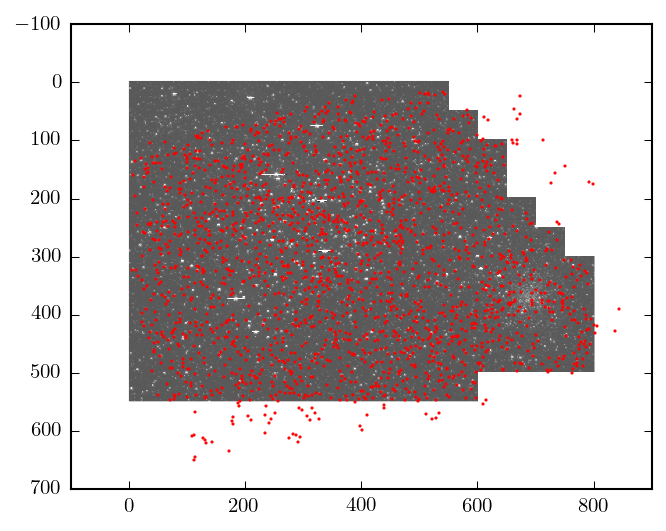

In [206]:
pl.imshow(np.log(data[-1]), cmap="gray", interpolation="nearest")
pl.plot(x, y, ".r", ms=2);

In [67]:
scaled = data  # / np.median(data, axis=0)[None, :, :]

In [68]:
data.shape

(1724, 550, 800)

In [538]:
X, Y = np.meshgrid(range(scaled.shape[1]), range(scaled.shape[2]), indexing="ij")
m = np.any(np.isfinite(scaled), axis=0)
pred = np.zeros_like(scaled)
count = np.zeros_like(scaled[0], dtype=int)
hw = 5
ex = hw + 10

cen = [258.794798, 272.821687]
xmn, xmx = int(cen[1] - 5), int(cen[1] + 5)
ymn, ymx = int(cen[0] - 4), int(cen[0] + 4)

# xmn, xmx = 575, 585
# ymn, ymx = 515, 525

# for i, j in product(range(0, scaled.shape[1], hw+1), range(0, scaled.shape[1], hw+1)):
for i, j in product(range(xmn, xmx, hw+1), range(ymn, ymx, hw+1)):
    # Select target and predictor pixels.
    window = m & (i - hw <= X) & (X <= i + hw) & (j - hw <= Y) & (Y <= j + hw)
    r2 = (X-i)**2 + (Y-j)**2
    others = m & ((i - ex > X) | (X > i + ex) | (j - ex > Y) | (Y > j + ex)) & (r2 < 25**2)
    print(i, j, window.sum(), others.sum())

    if not (np.any(window) and np.any(others)):
        continue
    
    A = np.concatenate((scaled[:, others], np.ones((len(scaled), 1))), axis=1)
    ATA = np.dot(A.T, A)
    ATA[np.diag_indices_from(ATA)] += 1e-2
    factor = cho_factor(ATA, overwrite_a=True)
    # y = np.concatenate((scaled[:, window], np.zeros((len(emp), window.sum()))), axis=0)
    y = scaled[:, window]
    w = cho_solve(factor, np.dot(A.T, y))

    pred[:, window] += np.dot(A[:len(scaled)], w)
    count[window] += 1

267 254 121 980
267 260 121 980
273 254 121 980
273 260 121 980


In [539]:
pred[:, count > 0] /= count[count > 0]

In [540]:
d = (scaled[:, xmn:xmx, ymn:ymx] - pred[:, xmn:xmx, ymn:ymx])
np.unravel_index(np.argmax(np.abs(d)), d.shape)

(1649, 9, 2)

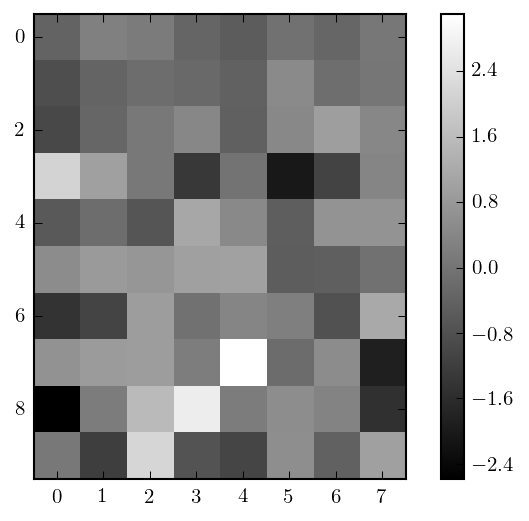

In [541]:
n = 100
pl.imshow(data[n, xmn:xmx, ymn:ymx] - pred[n, xmn:xmx, ymn:ymx], cmap="gray", interpolation="nearest")
pl.colorbar()

In [542]:
d = data[:, xmn:xmx, ymn:ymx] - pred[:, xmn:xmx, ymn:ymx]
block = d.reshape((len(d), -1))
# block = block / np.median(block, axis=0) - 1

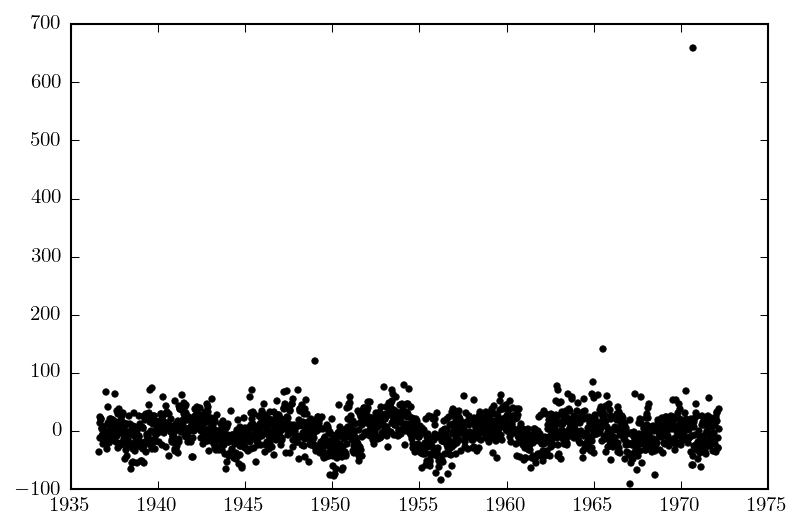

In [543]:
pl.plot(time, np.sum(block, axis=1), ".k")
# pl.plot(time, np.sum(block, axis=1), ".k")

In [550]:
model = FastICA(n_components=2)
model.fit(block.T)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=2, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [551]:
n = len(model.components_)
print(n)

2


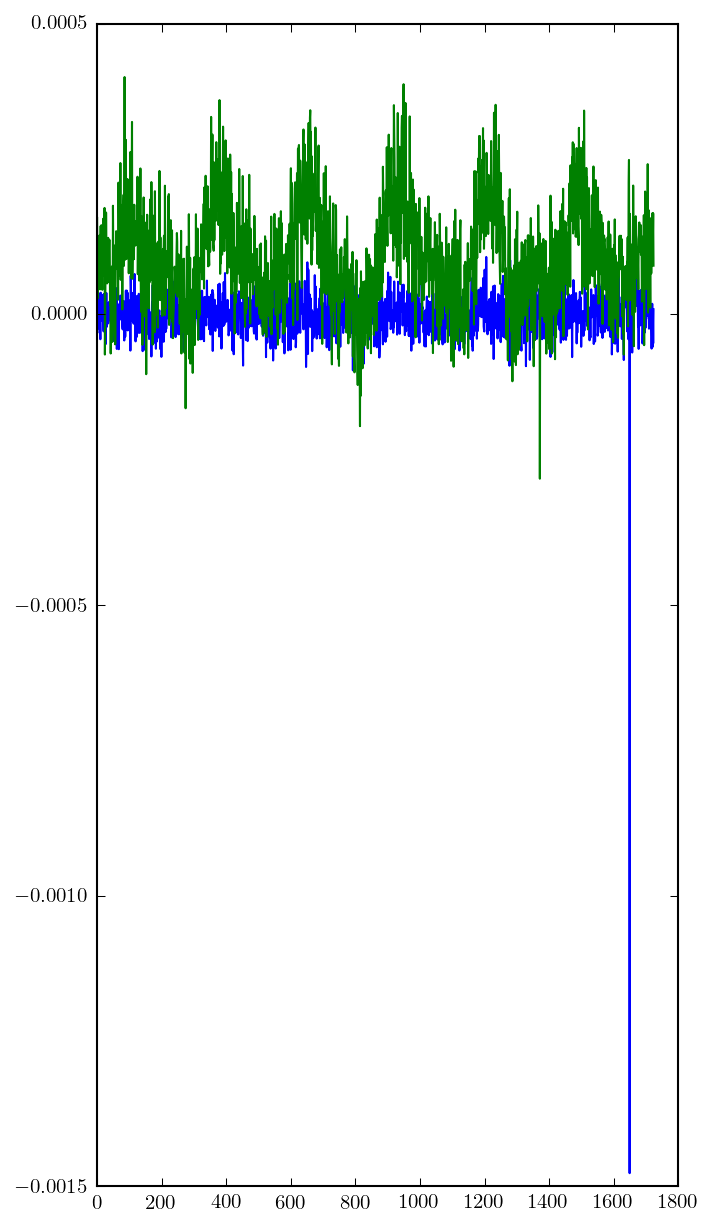

In [552]:
pl.figure(figsize=(5, 10))
pl.plot(model.components_.T + 1e-4*np.arange(n));

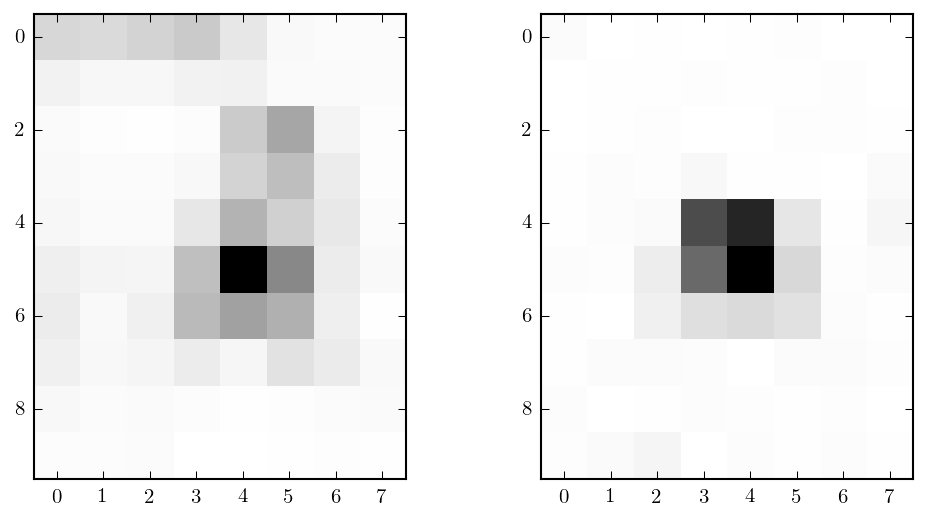

In [553]:
fig, axes = pl.subplots(1, 2, figsize=(8, 4))
v = model.components_[1]
comp = np.abs((np.dot(v, block)).reshape(d[0].shape))

axes[0].imshow(np.log(data[0, xmn:xmx, ymn:ymx]), cmap="gray_r", interpolation="nearest")
axes[1].imshow(comp, cmap="gray_r", interpolation="nearest")

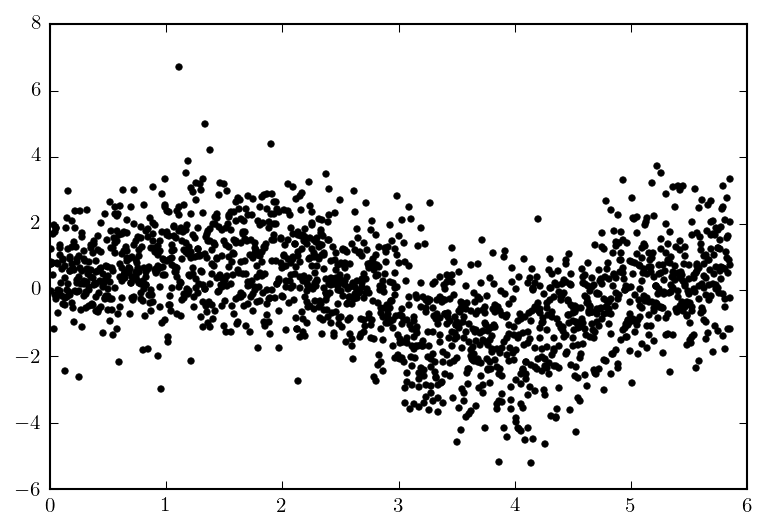

In [557]:
c = np.dot(v, block)
c /= np.sum(c)

t = time % 5.862149

# y = np.sum(block, axis=1)
# pl.plot(t, y / np.median(np.abs(np.diff(y))), ".g")

y = np.sum(c * block, axis=1)
pl.plot(t, y / np.median(np.abs(np.diff(y))), ".k")


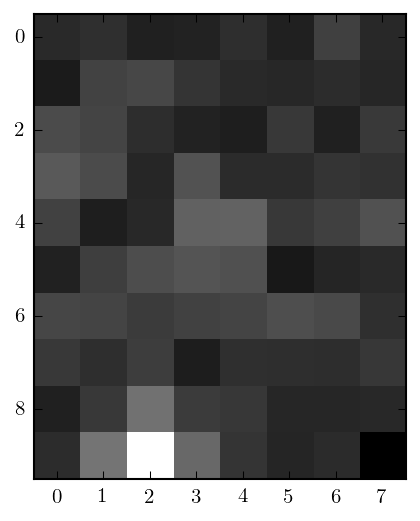

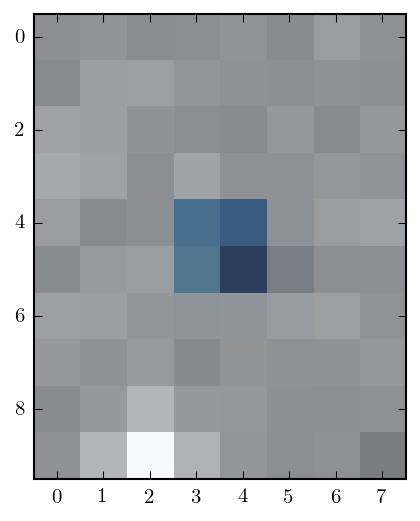

In [556]:
pl.figure()
pl.imshow(d[0], cmap="gray_r", interpolation="nearest")
pl.figure()
pl.imshow(d[0], cmap="gray_r", interpolation="nearest")
pl.imshow(comp, cmap="Blues", interpolation="nearest", alpha=0.5);